# Generate Standard Data

In [1]:
alpha_name = "AlphaNetV1_Original_Input_1208"
path = "/home/wuwenjun/Alpha_Factor/" + alpha_name + "/result/"
output_path = r'/home/wuwenjun/factor_lib/ti0/wuwenjun'

In [39]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
from os import walk
import pandas as pd
import numpy as np
import torch
from datetime import datetime
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm

In [56]:
# 生成标准数据
df = pd.DataFrame()
for f, _, i in walk(path):
    for j in tqdm(i):
        df = pd.concat([df,pd.read_csv(f + "/" + j)],axis=0)
df.rename(columns={'AlphaNet': alpha_name}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str))
display(df)
# output
convert_to_standard_daily_feature_csv(alpha_name, df.drop("target",axis=1), output_path)

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


,timestamp,symbol,AlphaNetV1_Original_Input_1208,target
0,2019-01-02 09:30:00,1,0.001571,0.037274
1,2019-01-03 09:30:00,1,0.060317,0.075163
2,2019-01-04 09:30:00,1,0.174096,0.094156
3,2019-01-07 09:30:00,1,0.301100,0.038618
4,2019-01-08 09:30:00,1,0.143749,0.039054
...,...,...,...,...
451179,2021-06-23 09:30:00,601399,-0.001553,-0.017544
451180,2021-06-24 09:30:00,601399,-0.029387,-0.020649
451181,2021-06-25 09:30:00,601399,0.019083,-0.011940
451182,2021-06-28 09:30:00,601399,0.005569,-0.052326


# Loop Back Test

In [74]:
import time
from Research.backtest.bt import BTDaily
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
import numpy as np
   
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/wuwenjun/factor_lib")
alpha_list = list(FT.features_in_path.keys())[-1:]
print(alpha_list)
start_date = '2019-01-01'
end_date = '2021-01-01'
FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                       timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
    FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
                                     period=('1d', '3d', '5d'))
    ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
    df, df_all = FT.get_ic_summary_by_month(num=6)

    if trading_direction == -1:
        negative = True
    else:
        negative = False
    FT.get_top_return(alpha_name, negative= False, trade_type='long-only', transmission_rate=0.0,
                            tax_rate=0.0015, verbose=True)

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


  0%|                                                                                                                         | 0/487 [00:00<?, ?it/s]

['AlphaNetV1_Original_Input_1208']


Calculating IC value...: 100%|█████████████████████████████████████████████████████████████████████████████████████| 487/487 [00:01<00:00, 271.59it/s]



IC table for feature "AlphaNetV1_Original_Input_1208" (mean std IR):
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      period       |  IC_AlphaNetV1_1d  |  IC_AlphaNetV1_2d  |  IC_AlphaNetV1_3d  |  IC_AlphaNetV1_4d  |  IC_AlphaNetV1_5d  |
+===================+====================+====================+====================+====================+====================+
| 20190102-20190630 |  1.70 12.41 0.14   |  2.21 14.10 0.16   |  2.30 14.31 0.16   |  2.83 14.54 0.19   |  3.23 14.38 0.22   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20190701-20191231 |   1.50 4.38 0.34   |   1.76 4.45 0.40   |   1.78 4.80 0.37   |   1.87 4.97 0.38   |   2.12 5.19 0.41   |
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 20200101-20200630 |   0.92 5.25 0.18   

Getting BT result for date: 20201231...: 100%|██████████████████████████████████████████████████████████████████████| 487/487 [00:08<00:00, 54.39it/s]



AlphaNetV1_Original_Input_1208 back-test result for long-only mode:

Back test summary: "long-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20190630 |     213     |  -6.45   |   9.05    |   -12.74   |  -1.66   |    50.43    | 12.22(20190103-20190312) |  1.32(20190222)   |   35.89    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
| 20190701-20191231 |     495     |  -8.38   |   4.17    |   -15.42   |  -4.20   |    37.60    | 9.49(2019071

In [75]:
import Research.utils.namespace as namespace
import numpy as np
 
from Research.feature.ft import FeatureAnalysis
from Research.utils import normalization as norm
 
config_path = r'/home/ShareFolder/lgc/Modules/Research/config/feature_bt_template'
print('Loading the configuration from ' + config_path)
configs = namespace.load_namespace(config_path)
FT = FeatureAnalysis(configs, feature_path=r"/home/ShareFolder/factor_lib")

alpha_list = list(FT.features_in_path.keys())[-1:]
start_date = '2019-01-01'
end_date = '2021-01-01'


FT.load_feature_from_file(alpha_list, start_date, end_date, universe='Investable',
                                   timedelta=None, transformer=norm.standard_scale)
FT.load_return_data()

for alpha_name in alpha_list:
#     FT.get_intersection_ic(feature_name=alpha_name, truncate_fold=None, method='spearman',
#                            period=('1d', '3d', '5d'))
#     ic_flag, trading_direction = FT.test_ic(alpha_name, verbose=False)
#     df, df_all = FT.get_ic_summary_by_month(num=6)
#     if trading_direction == -1:
#         negative = True
#     else:
#         negative = False

    result, holdings = FT.get_group_returns(alpha_name, negative=True,group_num=20)

    # result为输入特征文件回测的结果，数据类型为DataFrame， holdings为分组的每日持仓，数据类型为字段，取第一组的持仓，查询holdings[0]即可，返回值为以日期为key的字典。
    print(result.head())
    print(holdings[0])

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


Getting BT result for date: 20201231...: 100%|█████████████████████████████████████████████████████████████████████▊| 486/487 [00:22<00:00, 29.78it/s]

           alpha_group0  alpha_group1  alpha_group2  alpha_group3  \
timestamp                                                           
20190102       1.000745      1.003399      1.006912      1.007949   
20190103       1.001944      1.000154      1.004927      1.004043   
20190104       1.002062      0.997725      1.006018      1.002758   
20190107       0.997749      0.999203      1.007818      1.006156   
20190108       1.001667      1.000604      1.009459      1.009203   

           alpha_group4  alpha_group5  alpha_group6  alpha_group7  \
timestamp                                                           
20190102       1.007670      1.006027      1.005923      1.004142   
20190103       1.003026      0.999307      1.007294      1.000247   
20190104       1.002828      0.997282      1.009611      1.002852   
20190107       1.005686      0.997958      1.013769      1.003515   
20190108       1.006245      1.000432      1.016838      1.004128   

           alpha_group8  alpha_g

In [76]:
result

,alpha_group0,alpha_group1,alpha_group2,alpha_group3,alpha_group4,alpha_group5,alpha_group6,alpha_group7,alpha_group8,alpha_group9,...,stock_num_group11,stock_num_group12,stock_num_group13,stock_num_group14,stock_num_group15,stock_num_group16,stock_num_group17,stock_num_group18,stock_num_group19,benchmark_value
timestamp,,,,,,,,,,,,,,,,,,,,,
20190102,1.000745,1.003399,1.006912,1.007949,1.007670,1.006027,1.005923,1.004142,1.009314,1.007296,...,173,172,172,171,173,170,171,173,172,0.989427
20190103,1.001944,1.000154,1.004927,1.004043,1.003026,0.999307,1.007294,1.000247,1.006841,1.009435,...,167,173,171,175,171,173,173,171,171,0.984842
20190104,1.002062,0.997725,1.006018,1.002758,1.002828,0.997282,1.009611,1.002852,1.007176,1.009741,...,173,174,172,172,173,173,174,171,170,1.008326
20190107,0.997749,0.999203,1.007818,1.006156,1.005686,0.997958,1.013769,1.003515,1.011365,1.013227,...,174,173,172,174,172,173,175,173,161,1.026870
20190108,1.001667,1.000604,1.009459,1.009203,1.006245,1.000432,1.016838,1.004128,1.012207,1.017509,...,175,173,173,172,173,172,174,173,162,1.024230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201225,0.423631,0.654072,0.707456,0.830805,0.807260,0.909654,1.005565,1.033023,1.187281,1.052536,...,191,191,190,192,190,193,188,190,182,1.503432
20201228,0.419473,0.649546,0.702780,0.825348,0.800433,0.904201,0.996976,1.023980,1.180462,1.044130,...,193,190,191,193,192,191,192,189,186,1.495287
20201229,0.421473,0.651334,0.704696,0.828267,0.805768,0.908068,1.005004,1.031893,1.188201,1.048327,...,191,190,192,191,195,188,194,190,182,1.484600


<AxesSubplot:xlabel='timestamp'>

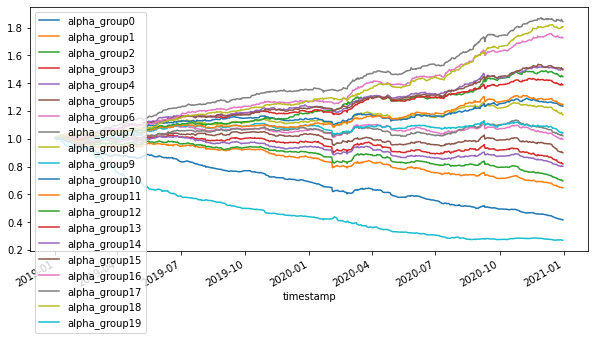

In [78]:
result.index = result.index.map(lambda x : pd.to_datetime(str(x)))
result.iloc[:,:20].plot(figsize=(10,5))

In [57]:
df.rename(columns = {"symbol":"ticker","timestamp":"date"},inplace=True)
df = df[['date','ticker',alpha_name]]
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
df.set_index("date",inplace=True)
df

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,1,0.001571
20190103,1,0.060317
20190104,1,0.174096
20190107,1,0.301100
20190108,1,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [58]:
df['ticker'] = df['ticker'].apply(lambda x : str(x).zfill(6))
data_frame = df.copy()
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [61]:
data_frame

,ticker,AlphaNetV1_Original_Input_1208
date,,
20190102,000001,0.001571
20190103,000001,0.060317
20190104,000001,0.174096
20190107,000001,0.301100
20190108,000001,0.143749
...,...,...
20210623,601399,-0.001553
20210624,601399,-0.029387
20210625,601399,0.019083


In [22]:
# time_df = pd.DataFrame(df['date'].drop_duplicates())
# time_df['year'] = time_df['date'].apply(lambda x : str(x.year))
# time_df['month'] = time_df['date'].apply(lambda x : str(x.month).zfill(2))
# time_df['day'] = time_df['date'].apply(lambda x : str(x.day).zfill(2))
# time_df['date_convert'] = time_df["year"] + time_df['month'] + time_df['day']
# time_df = time_df[["date","date_convert"]]
# df = pd.merge(df,time_df,left_on = "date" , right_on = "date",how="left")
# df['date'] = df['date_convert']
# df.drop('date_convert',axis=1,inplace=True)
# df.set_index("date",inplace=True)
# df

,date,date_convert
0,2019-01-02 09:30:00,20190102
1,2019-01-03 09:30:00,20190103
2,2019-01-04 09:30:00,20190104
3,2019-01-07 09:30:00,20190107
4,2019-01-08 09:30:00,20190108
...,...,...
112,2021-06-23 09:30:00,20210623
113,2021-06-24 09:30:00,20210624
114,2021-06-25 09:30:00,20210625
115,2021-06-28 09:30:00,20210628


In [71]:
config_path = r'/home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template'
print('Loading the configuration from ' + config_path)
bt_price = "close"

start_date = '2019-01-02'
end_date = '2021-06-30'
configs = namespace.load_namespace(config_path)
configs.trading_type = 'long-only'
configs.data_format = 'dataframe'
configs.ti = 0
configs.trade_period = 0
configs.stock_percentage = False
configs.stock_num = 100
configs.transmission_rate = 0.0
configs.benchmark = "ZZ500"
configs.bt_price = bt_price
configs.universe = "Investable"
#configs.score_sorted = False
configs.keep_pos_percentile = 0.0

# df = standard_res.reset_index()

# df.columns = ['date', 'ticker', 'model']
# #df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y%m%d').astype(int)
# df.set_index('date', inplace=True)
#####################################

bt = BTDaily(configs, start_date=start_date, end_date= end_date)

bt.feed_data(data_frame)
bt.run()
start =int(datetime.strptime(start_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
end = int(datetime.strptime(end_date, '%Y-%m-%d').date().strftime('%Y%m%d'))
df, df_final = bt.evaluate(evalRange=((start, end),))

  0%|                                                                                                                         | 0/605 [00:00<?, ?it/s]

Loading the configuration from /home/ShareFolder/lgc/Modules/Platform/config/combo_bt_template


Getting BT result for date: 20210630...: 100%|██████████████████████████████████████████████████████████████████████| 605/605 [00:45<00:00, 13.20it/s]



Back test summary: "short-only" mode
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
|      period       |  stock_num  |  return  |  ret_std  |  ret_year  |  sharpe  |  win_ratio  |      max_dd|period       |  max_dd_day|date  |  turnover  |
+===================+=============+==========+===========+============+==========+=============+==========================+===================+============+
| 20190102-20210630 |     222     |  39.77   |   13.88   |   14.27    |   0.99   |    54.30    | 13.56(20190404-20191112) |  4.89(20200203)   |   39.67    |
+-------------------+-------------+----------+-----------+------------+----------+-------------+--------------------------+-------------------+------------+
